# Model V27

## Data Loading

In [6]:
import os
from pathlib import Path

BATCH_SIZE = 32
DATA_DIRS = [ 4, 5, 6]

data_dirs = [Path.cwd() / '..' / f'data_{i}' for i in DATA_DIRS]

print("Data directories:")
for d in data_dirs:
    print(d, sep="\n")

def dataset_file_get_timestamp(file: Path):
    return int(file.stem.split('_')[0])

def dataset_file_get_steering_angle(file: Path):
    return float(file.stem.split('_')[1].replace('-', '.'))

# Function to load images and steering angles from multiple directories
def load_data(directories, data_type='train'):
    assert(data_type in ['train', 'test'])
    image_paths = []
    steering_angles = []

    for directory in directories:
        ip_section = []
        sa_section = []
        data_dir = directory / data_type

        # Load images from the directory
        for file_ in os.listdir(data_dir):
            if file_.endswith(".png"):  
                ip_section.append(data_dir / file_)

        # Sort images by timestamp in filename
        ip_section.sort(key=dataset_file_get_timestamp)

        # Extract steering angles from filenames
        for path in ip_section:
            sa_section.append(dataset_file_get_steering_angle(path))
        
        image_paths.extend(ip_section)
        steering_angles.extend(sa_section)

    return image_paths, steering_angles

train_img, train_steer = load_data(data_dirs, 'train')
test_img, test_steer = load_data(data_dirs, 'test')

Data directories:
/home/julish/git/apsc258/labs/lab7/models/../data_4
/home/julish/git/apsc258/labs/lab7/models/../data_5
/home/julish/git/apsc258/labs/lab7/models/../data_6


## Dataset Visualization

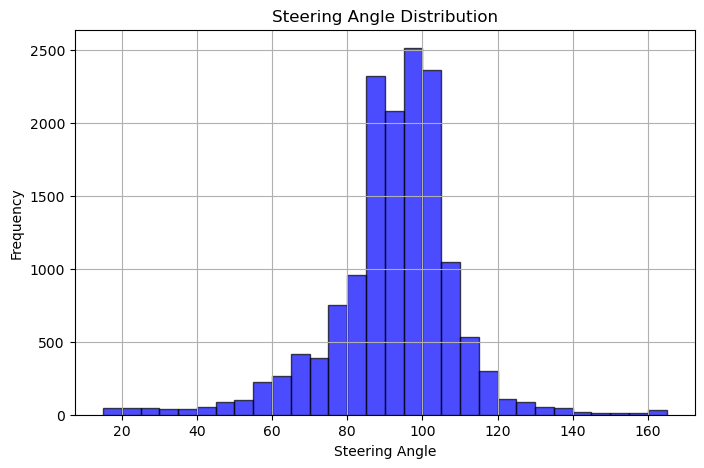

In [7]:
import matplotlib.pyplot as plt

# Function to plot steering angle distribution
def plot_steering_angle_distribution(steering_angles):
    """
    Plots a histogram of steering angles to check data distribution.
    """
    plt.figure(figsize=(8, 5))
    plt.hist(steering_angles, bins=30, color='blue', alpha=0.7,
             edgecolor='black')
    plt.xlabel("Steering Angle")
    plt.ylabel("Frequency")
    plt.title("Steering Angle Distribution")
    plt.grid(True)
    plt.show()

# Plot steering angle distribution
plot_steering_angle_distribution(train_steer)

## Dataset Pre-processing

In [8]:
import cv2 as cv
import numpy as np
import tensorflow as tf
import tqdm

BATCH_SIZE = 50
RAND_SEED = 42
SHUFFLE_BUFFER_DIVIDER = 1
PREFETCH_BUFFER_SIZE = 500

def process_image(image_path):
    """Function to load and preprocess images."""
    # read the image
    img = cv.imread(image_path) 
    # convert the image to HSV
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    # mask the image to get only the desired colors
    mask = cv.inRange(hsv, (36, 0, 0), (70, 255,255))
    # apply the mask to the image and normalize the values
    array = np.array(mask, dtype=np.float32)
    return array

train_data = []
test_data = []

tqdm.tqdm.write("Loading training data")
# load the images and steering angles into numpy arrays
for path in tqdm.tqdm(train_img):
    train_data.append(process_image(path))

tqdm.tqdm.write("Loading test data")
# loading the testing data
for path in tqdm.tqdm(test_img):
    test_data.append(process_image(path))

## create a dataset from the training data and make a data pipeline
# create a dataset from the image paths and steering angles
train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_steer))
# repeat the dataset
train_ds = train_ds.repeat()
# shuffle the dataset
train_ds = train_ds.shuffle(buffer_size=len(train_img) // SHUFFLE_BUFFER_DIVIDER,
                            seed=RAND_SEED)
# prefetch the dataset to improve performance
train_ds = train_ds.batch(BATCH_SIZE).prefetch(PREFETCH_BUFFER_SIZE)

## create a dataset from the testing data and make a data pipeline
# create a dataset from the image paths and steering angles
test_ds = tf.data.Dataset.from_tensor_slices((test_data, test_steer))
# repeat the dataset
test_ds = test_ds.repeat()
# batch the dataset
test_ds = test_ds.batch(BATCH_SIZE)
# prefetch the dataset to improve performance
test_ds = test_ds.prefetch(PREFETCH_BUFFER_SIZE)

# output the first 16 images and steering angles from the dataset
fig, axs = plt.subplots(4, 4, figsize=(8, 8))

# get the first batch of images and steering angles
imgs, steer = next(iter(train_ds))

for i in range(16):
    axs[i//4, i%4].axis('off')
    axs[i//4, i%4].imshow(imgs[i])
    axs[i//4, i%4].set_title(f'angle: {round(steer[i].numpy(), 2):.2f}')

# add title to the figure
fig.suptitle('Training Data')
fig.tight_layout()

2025-04-03 04:39:11.484570: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-03 04:39:11.493119: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-03 04:39:11.496326: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-03 04:39:11.503948: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading training data


100%|██████████| 15000/15000 [00:02<00:00, 5087.34it/s]


Loading test data


100%|██████████| 9000/9000 [00:01<00:00, 5196.25it/s]

: 

## Model Design

In [ ]:
from keras import layers
from keras import models
from keras import optimizers

conv_params = {
    'kernel_size': (3,3),
    'activation': 'relu',
    'padding': 'same',
    'use_bias': False
}

model = models.Sequential([
    layers.Input(shape=(66, 100, 1)),

    # Feature Extraction
    layers.SeparableConv2D(8, **conv_params),
    layers.SeparableConv2D(8, **conv_params),
    layers.BatchNormalization(),
    layers.MaxPool2D((2,2)),

    layers.SeparableConv2D(16, **conv_params),
    layers.SeparableConv2D(16, **conv_params),
    layers.BatchNormalization(),
    layers.MaxPool2D((2,2)),

    layers.SeparableConv2D(32, **conv_params),
    layers.SeparableConv2D(32, **conv_params),
    layers.BatchNormalization(),
    layers.MaxPool2D((2,2)),

    layers.SeparableConv2D(64, **conv_params),
    layers.SeparableConv2D(64, **conv_params),
    layers.BatchNormalization(),
    layers.MaxPool2D((2,2)),

    layers.SeparableConv2D(128, **conv_params),
    layers.SeparableConv2D(128, **conv_params),
    layers.BatchNormalization(),
    layers.MaxPool2D((2,2)),
    layers.Dropout(0.5),

    # Feature Reduction
    layers.GlobalAvgPool2D(),

    # Fully Connected Layers
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    
    # Output Layer: Steering Angle (0-180 degrees)
    layers.Dense(1, activation='linear')  # Output raw angle
])

# Compile Model
optimizer = optimizers.Adam(0.002)
model.compile(optimizer=optimizer, loss='mse')

# Print Summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv2d_28             │ (None, 66, 100, 8)     │            17 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_29             │ (None, 66, 100, 8)     │           136 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 66, 100, 8)     │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 33, 50, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_30             │ (None, 33, 50, 16)     │           200 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_31             │ (None, 33, 50, 16)     │           400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 33, 50, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 16, 25, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_32             │ (None, 16, 25, 32)     │           656 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_33             │ (None, 16, 25, 32)     │         1,312 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 16, 25, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 8, 12, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_34             │ (None, 8, 12, 64)      │         2,336 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_35             │ (None, 8, 12, 64)      │         4,672 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 8, 12, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 4, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_36             │ (None, 4, 6, 128)      │         8,768 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_37             │ (None, 4, 6, 128)      │        17,536 │
│ (SeparableConv2D)               │                        │             

 Total params: 64,546 (252.13 KB)

 Trainable params: 64,050 (250.20 KB)

 Non-trainable params: 496 (1.94 KB)

Epoch 10: Loss = 34.5441, Val Loss = 60.3402
Epoch 20: Loss = 24.0322, Val Loss = 31.9288
Epoch 30: Loss = 18.4699, Val Loss = 8.3988
Epoch 40: Loss = 16.8031, Val Loss = 68.8299
Epoch 50: Loss = 17.1138, Val Loss = 6.4045
Epoch 60: Loss = 15.3519, Val Loss = 10.7144
Epoch 70: Loss = 13.9685, Val Loss = 5.5748
Epoch 80: Loss = 10.5083, Val Loss = 3.0597
Epoch 90: Loss = 9.6576, Val Loss = 5.7227
Epoch 100: Loss = 7.8920, Val Loss = 4.4216
Epoch 110: Loss = 6.0545, Val Loss = 3.1863
Epoch 120: Loss = 5.7956, Val Loss = 2.5796
Epoch 130: Loss = 4.4981, Val Loss = 2.8876
Epoch 140: Loss = 3.8879, Val Loss = 3.5801
Epoch 150: Loss = 4.0879, Val Loss = 4.3910
Epoch 160: Loss = 3.7561, Val Loss = 2.9632
Epoch 170: Loss = 3.1730, Val Loss = 2.7546
Epoch 180: Loss = 3.5643, Val Loss = 2.4248
Epoch 190: Loss = 2.8286, Val Loss = 2.3652
Epoch 200: Loss = 2.7176, Val Loss = 2.2399


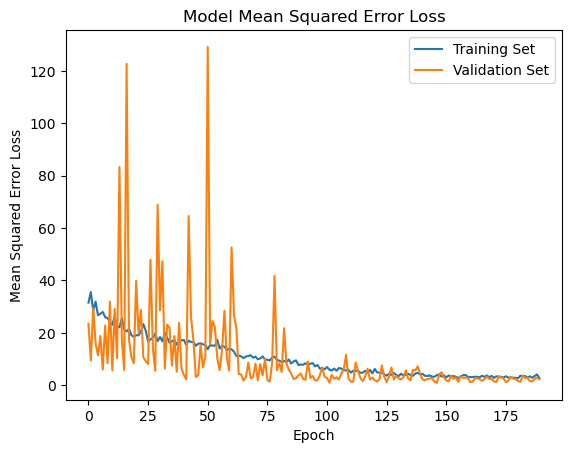

In [ ]:
from keras import callbacks

STEP_PREDIVIDER = 5
EPOCHS = 200

class EpochLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        """Logs training progress every 10 epochs."""
        if (epoch + 1) % 10 == 0:  # Log every 10 epochs
            print(f"Epoch {epoch+1}: Loss = {logs['loss']:.4f},",
                  f"Val Loss = {logs.get('val_loss', 'N/A'):.4f}")

epoch_logger = EpochLogger()
lr_schedule = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20)

hist = model.fit(train_ds,
                 steps_per_epoch=len(train_img) // BATCH_SIZE // STEP_PREDIVIDER,
                 validation_data=test_ds,
                 validation_steps=len(test_img) // BATCH_SIZE // STEP_PREDIVIDER,
                 epochs=EPOCHS,
                 verbose=0,
                 callbacks=[epoch_logger, lr_schedule])

# Plot the model's history
plt.plot(hist.history['loss'][10:])
plt.plot(hist.history['val_loss'][10:])
plt.title('Model Mean Squared Error Loss')
plt.ylabel('Mean Squared Error Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Validation Set'], loc='upper right')
plt.show()

In [ ]:
eval_out = model.evaluate(test_ds, steps=10)  # Helps stabilize BatchNorm running statistics
print(f"Test loss: {eval_out}")
prediction = model.predict(imgs[-1].numpy().reshape(1, 66, 100, 1))
print(f"Predicted steering angle: {prediction[0][0]:.2f}")
print(f"Actual steering angle: {steer[-1].numpy():.2f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.2058
Test loss: 4.463434219360352
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted steering angle: 123.47
Actual steering angle: 124.32


W0000 00:00:1742816402.986810   52454 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742816403.003532   52454 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742816403.005440   52454 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742816403.013157   52454 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742816403.014363   52454 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742816403.015854   52454 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742816403.019428   52454 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742816403.021676   52454 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1742816403.022886   52454 gp

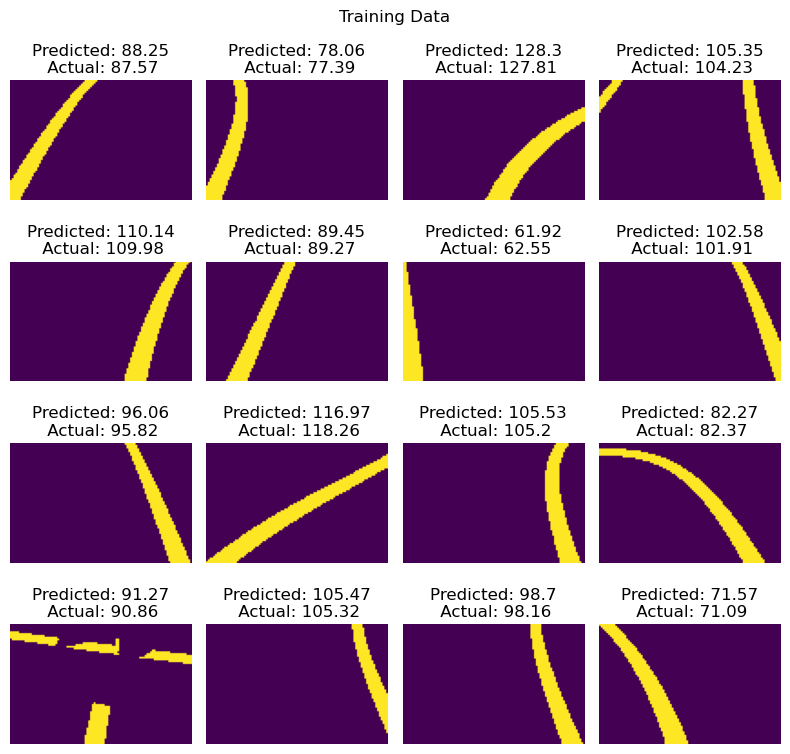

In [ ]:
def display_results():
    # output the first 16 images and steering angles from the test dataset then predict the steering angle for the images
    fig, axs = plt.subplots(4, 4, figsize=(8, 8))
    # add title to the figure
    fig.suptitle('Training Data')
    fig.tight_layout()

    #imgs, steer = next(iter(test_ds)) # get the first batch of images and steering angles

    for i in range(16):
        axs[i//4, i%4].axis('off')
        axs[i//4, i%4].imshow(imgs[i])
        axs[i//4, i%4].set_title(round(steer[i].numpy(), 2))
        predicted = model(imgs[i].numpy().reshape(1, 66, 100, 1)) # predict the steering angle for the image
        axs[i//4, i%4].set_title("Predicted: " + str(np.round(predicted[0][0].numpy(), 2)) + "\n Actual: " + str(round(steer[i].numpy(), 2)))
    plt.tight_layout()
    plt.show()

display_results()

In [ ]:
import onnx
import tf2onnx
import tensorflow as tf

model_name = "conv_model" # change the name to something more descriptive if you want
model.save(model_name + '.keras')
model.save(model_name + ".h5")
model.output_names = ['output']
input_signature = [tf.TensorSpec([None, 66, 100, 1], tf.float32, name='input')]

onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=input_signature, opset=13)

onnx.save(onnx_model, model_name + ".onnx")

I0000 00:00:1742816414.045017   52454 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1742816414.045757   52454 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-03-24 04:40:14.045877: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
I0000 00:00:1742816414.047289   52454 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1742816414.047328   52454 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1742816414.047343   52454 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been bui